In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd
import theano as th
import theano.tensor as tt
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sb
import g3py as g3
import pymc3 as pm

#g3.style_seaborn()
#g3.style_normal()
g3.style_big()
#g3.style_big_seaborn()
g3.style_widget()

# Data

In [2]:
# Sunsets
x, y = g3.load_sunspots()
obs_j, x_obs, y_obs, test_j, x_test, y_test = g3.random_obs(x, y, 0.15)

::

    Number of Observations - 309 (Annual 1700 - 2008)
    Number of Variables - 1
    Variable name definitions::

        SUNACTIVITY - Number of sunspots for each year

    The data file contains a 'YEAR' variable that is not returned by load.

Total: 309 | Obs: 46 (14.88673139158576%)


# BoxCoxGP

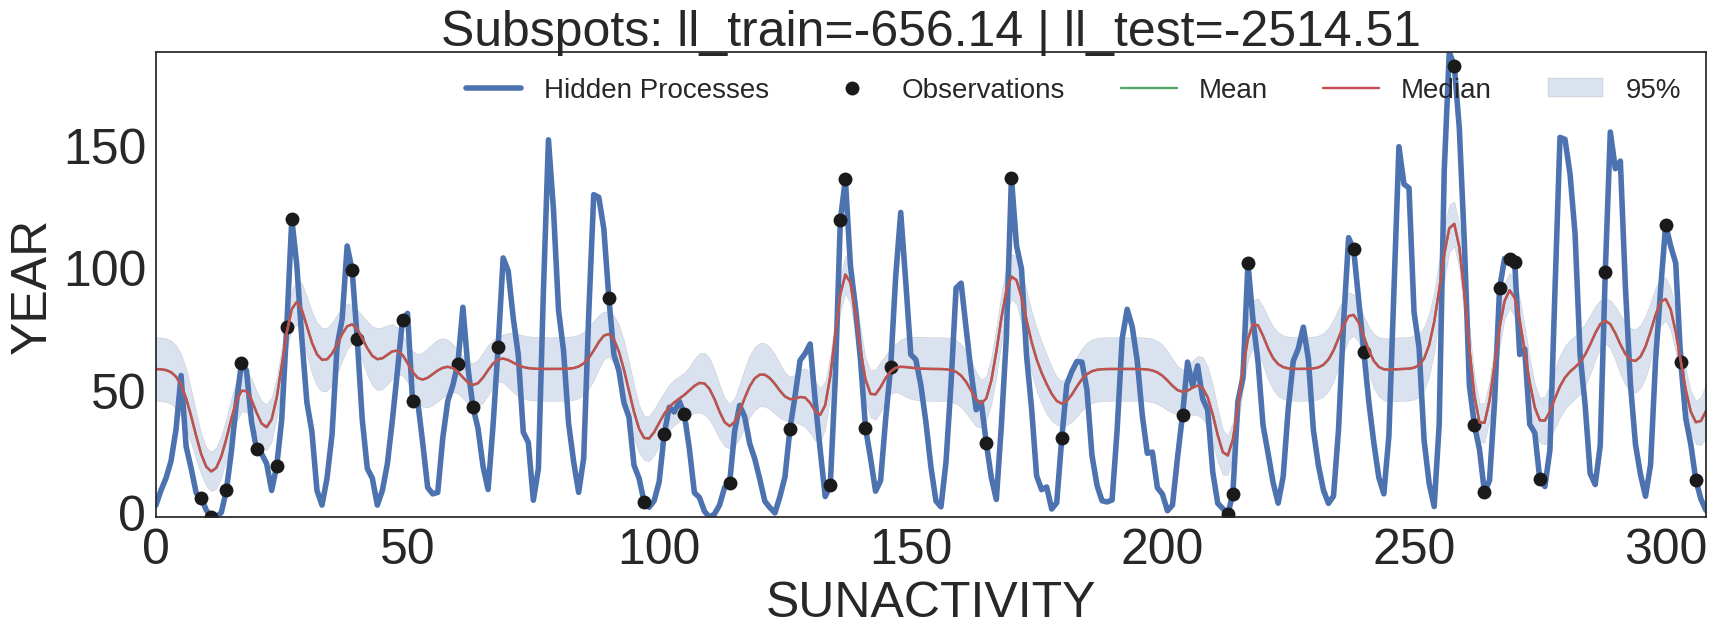

In [3]:
with g3.Model() as model:
    tgp = g3.TGP(x, g3.Bias(), g3.SE(x_obs), g3.BoxCoxShifted(y_obs), noise=True, hidden=y)
    tgp.describe('Subspots','SUNACTIVITY','YEAR')
    tgp.observed(x_obs,y_obs)
    tgp.testing(x_test,y_test)
    tgp.compile()
tgp.plot_tgp(tgp.find_default())

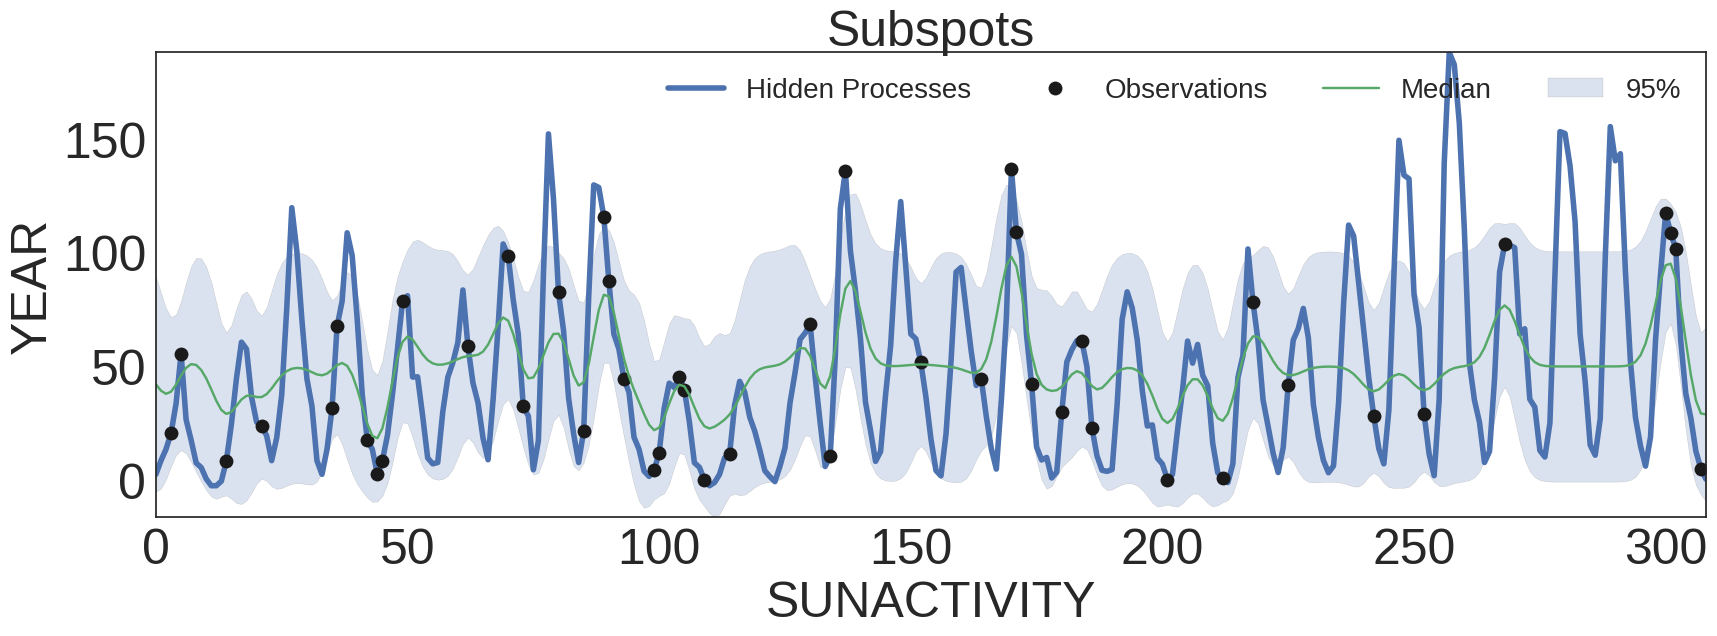

In [27]:
tgp.widget_params()

         Current function value: 231.898849
         Iterations: 19
         Function evaluations: 88
         Gradient evaluations: 81
Optimization terminated successfully.
         Current function value: 224.530533
         Iterations: 11
         Function evaluations: 1179
         Current function value: 230.959091
         Iterations: 2
         Function evaluations: 58
         Gradient evaluations: 55
Optimization terminated successfully.
         Current function value: 212.360352
         Iterations: 13
         Function evaluations: 1340
         Current function value: 224.530533
         Iterations: 0
         Function evaluations: 30
         Gradient evaluations: 18
Optimization terminated successfully.
         Current function value: 220.978302
         Iterations: 8
         Function evaluations: 901


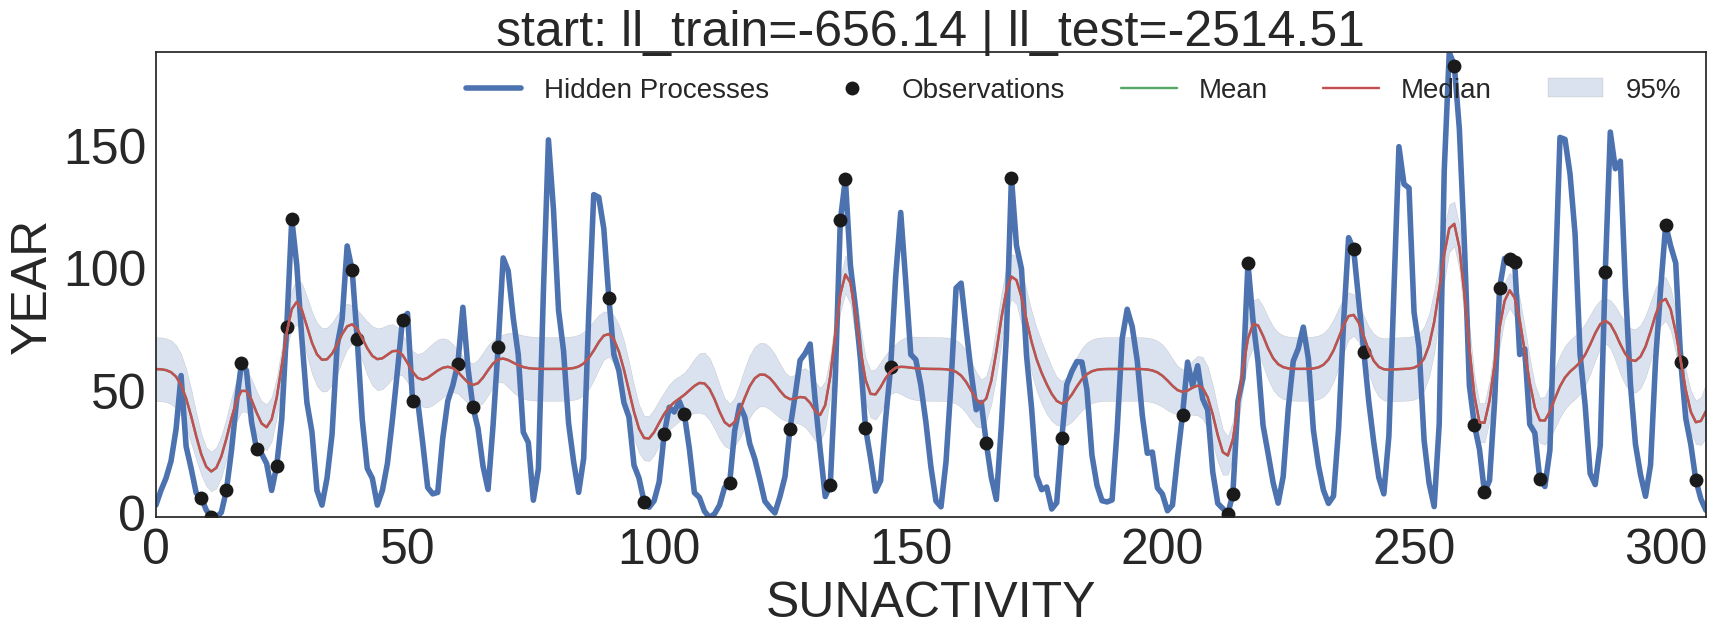

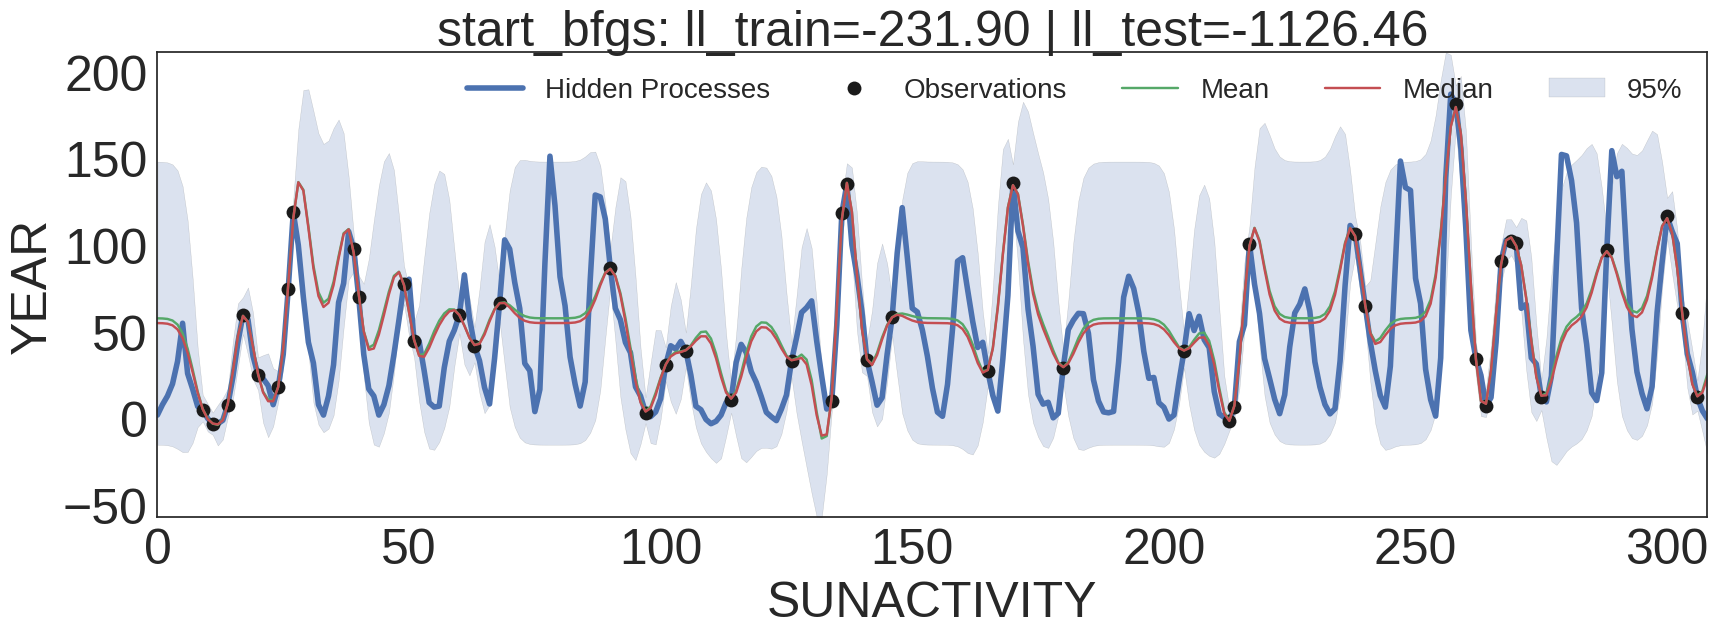

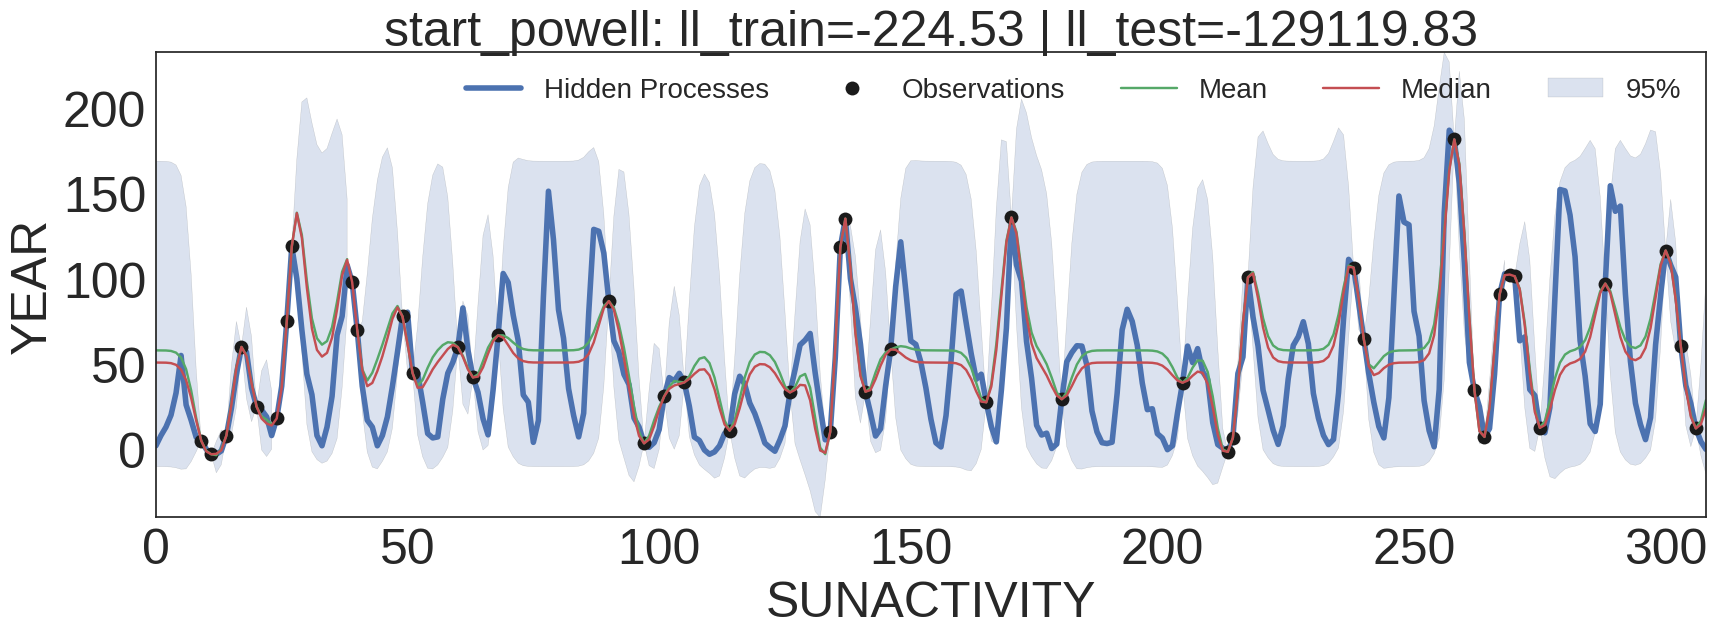

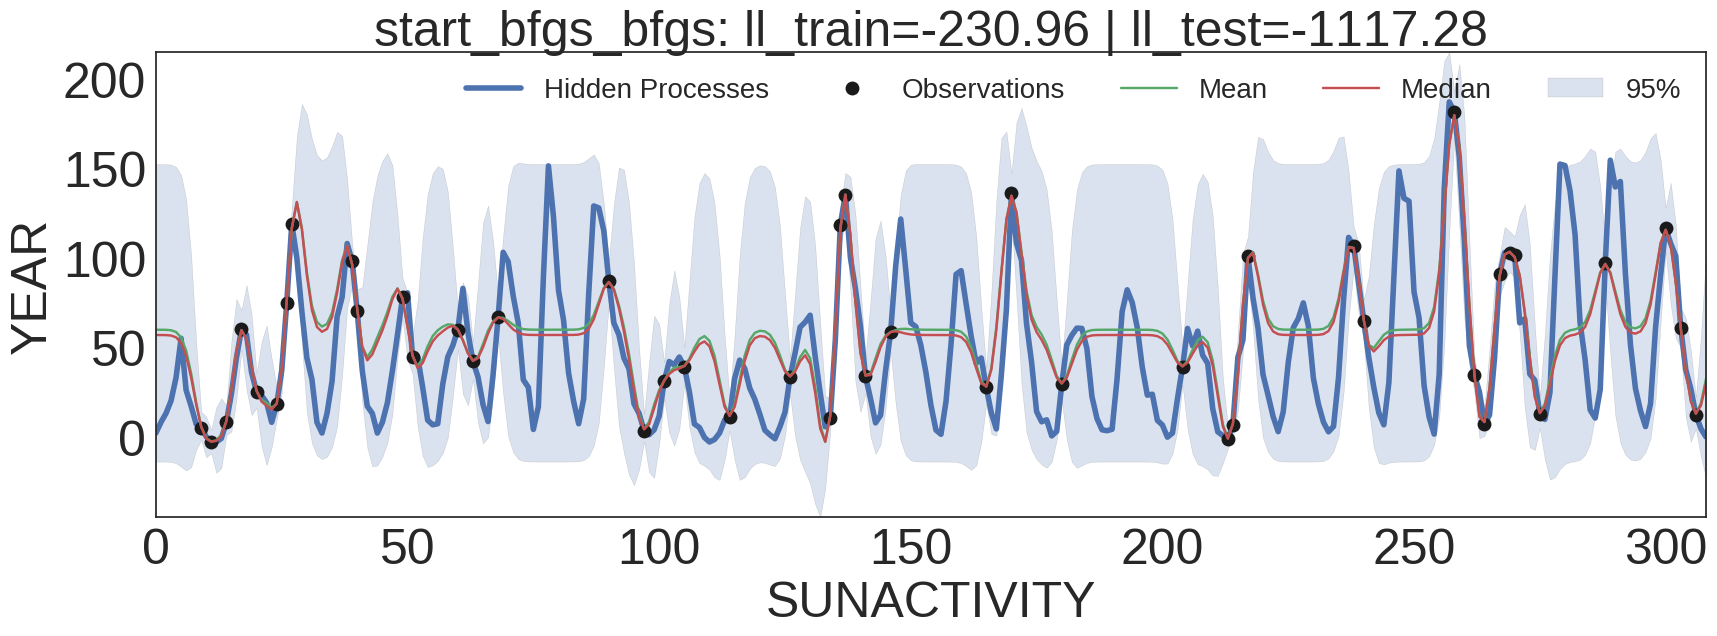

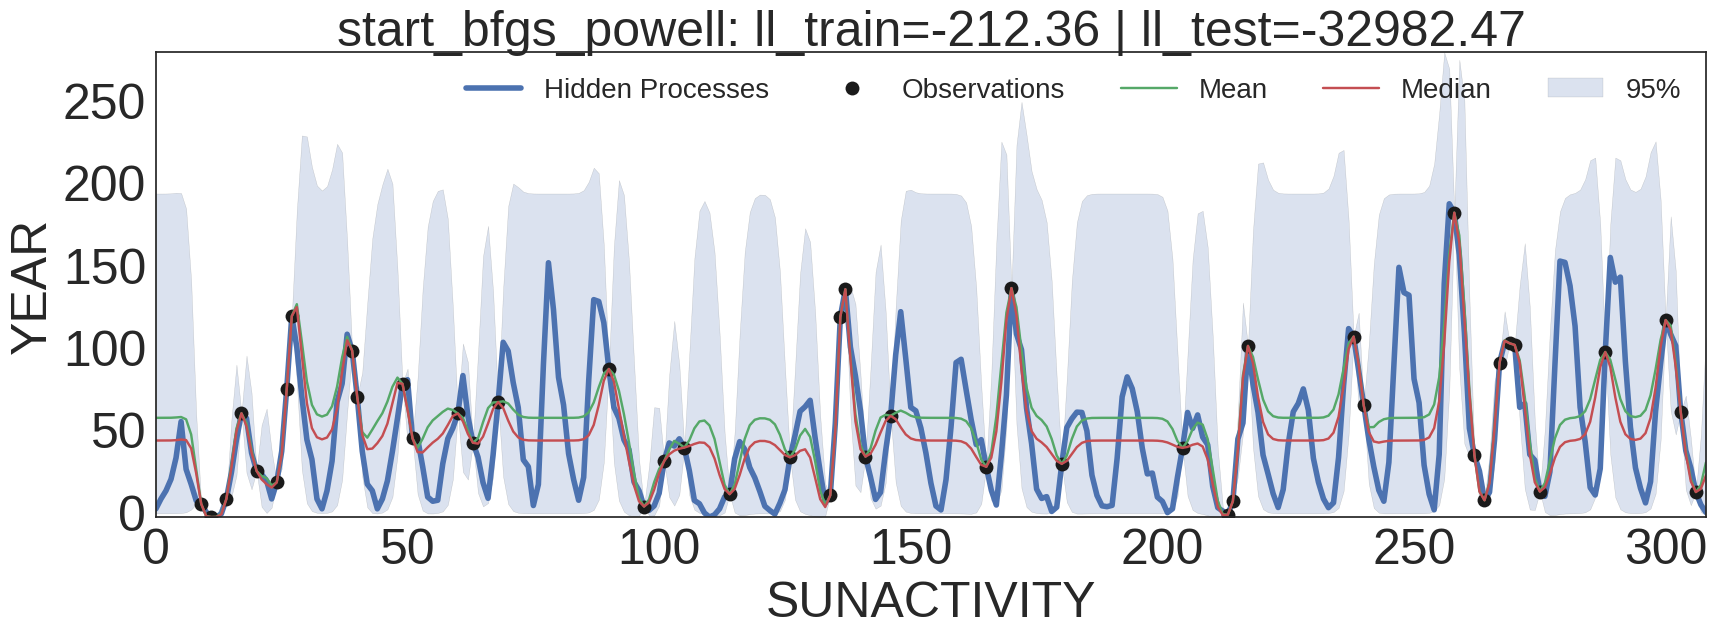

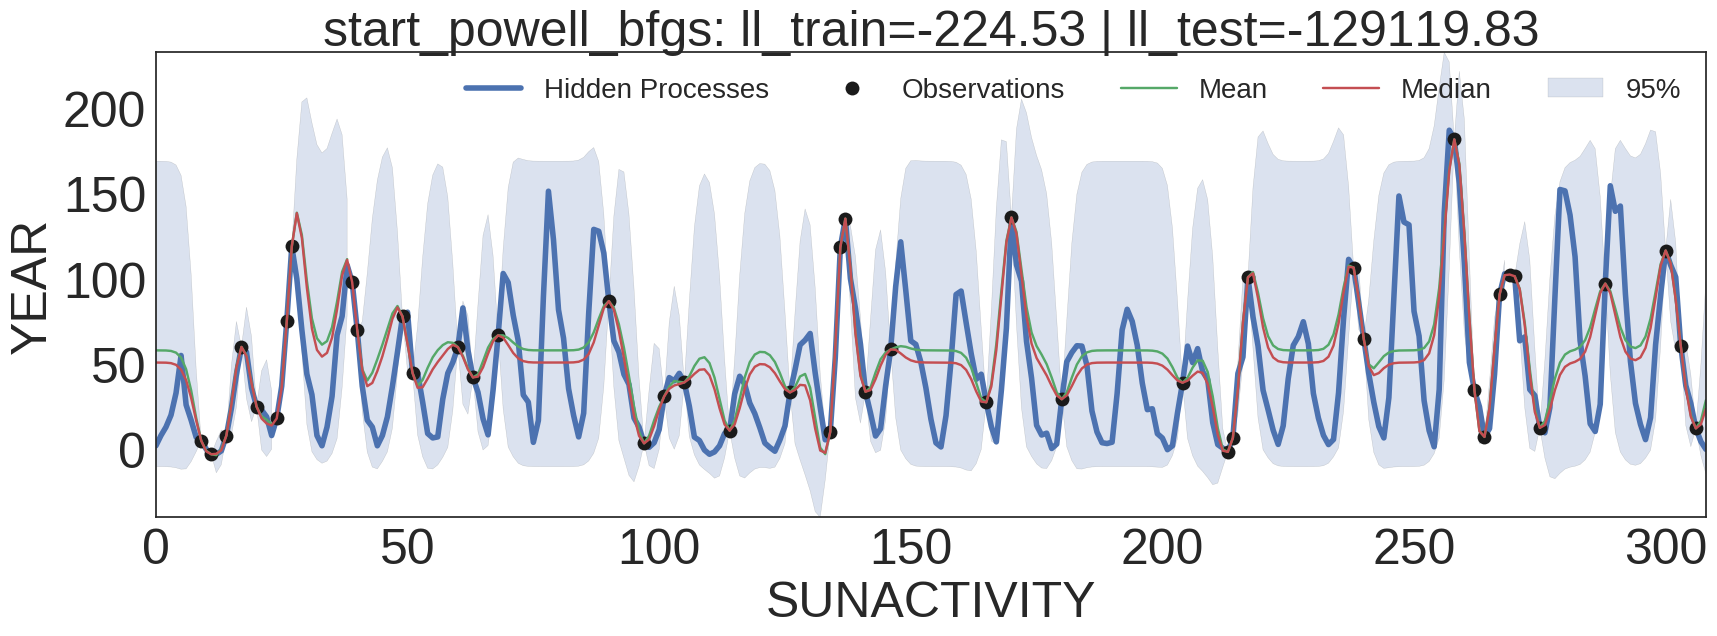

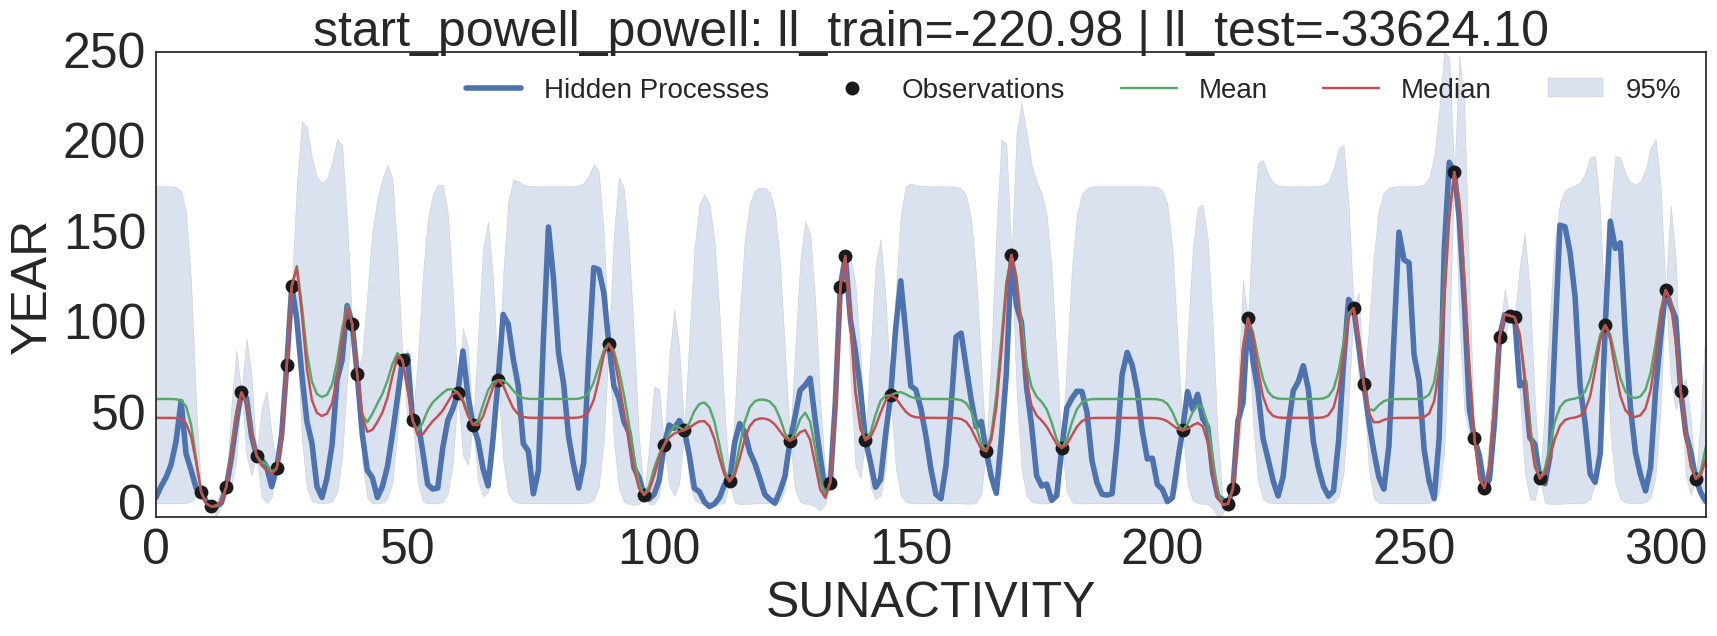

In [4]:
points = tgp.find_MAP(tgp.get_params(), 6, plot=True)

{'TGP_Bias_Constant': array(8.033319473266602, dtype=float32),
 'TGP_BoxCoxShifted_power_log_': array(-1.0588542222976685, dtype=float32),
 'TGP_BoxCoxShifted_shift': array(-4.38301304972466e-12, dtype=float32),
 'TGP_Noise_Var_log_': array(-12.652286529541016, dtype=float32),
 'TGP_SE_ARD_L2_Scales_log_': array(1.201426386833191, dtype=float32),
 'TGP_SE_Var_log_': array(2.5694894790649414, dtype=float32)}

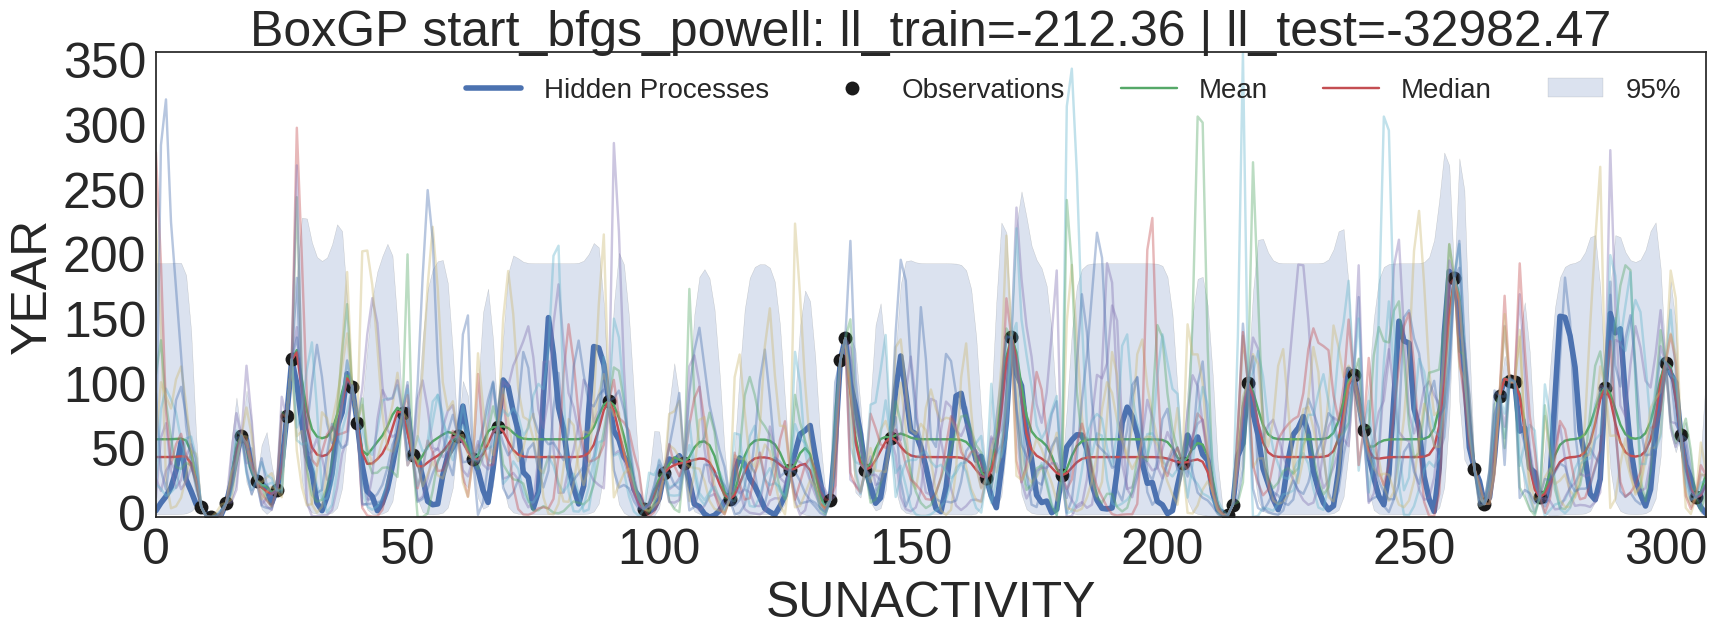

In [22]:
optimal = points[0]
for test in points:
    if test[1] > optimal[1]:
        optimal = test
name, logp, params = optimal

tgp.plot_tgp(params,'BoxGP '+name, samples=10)
g3.save_plot('bcgp_optimal.pdf')

params

In [ ]:
traces = tgp.sample_hypers(start=params, samples=5000)

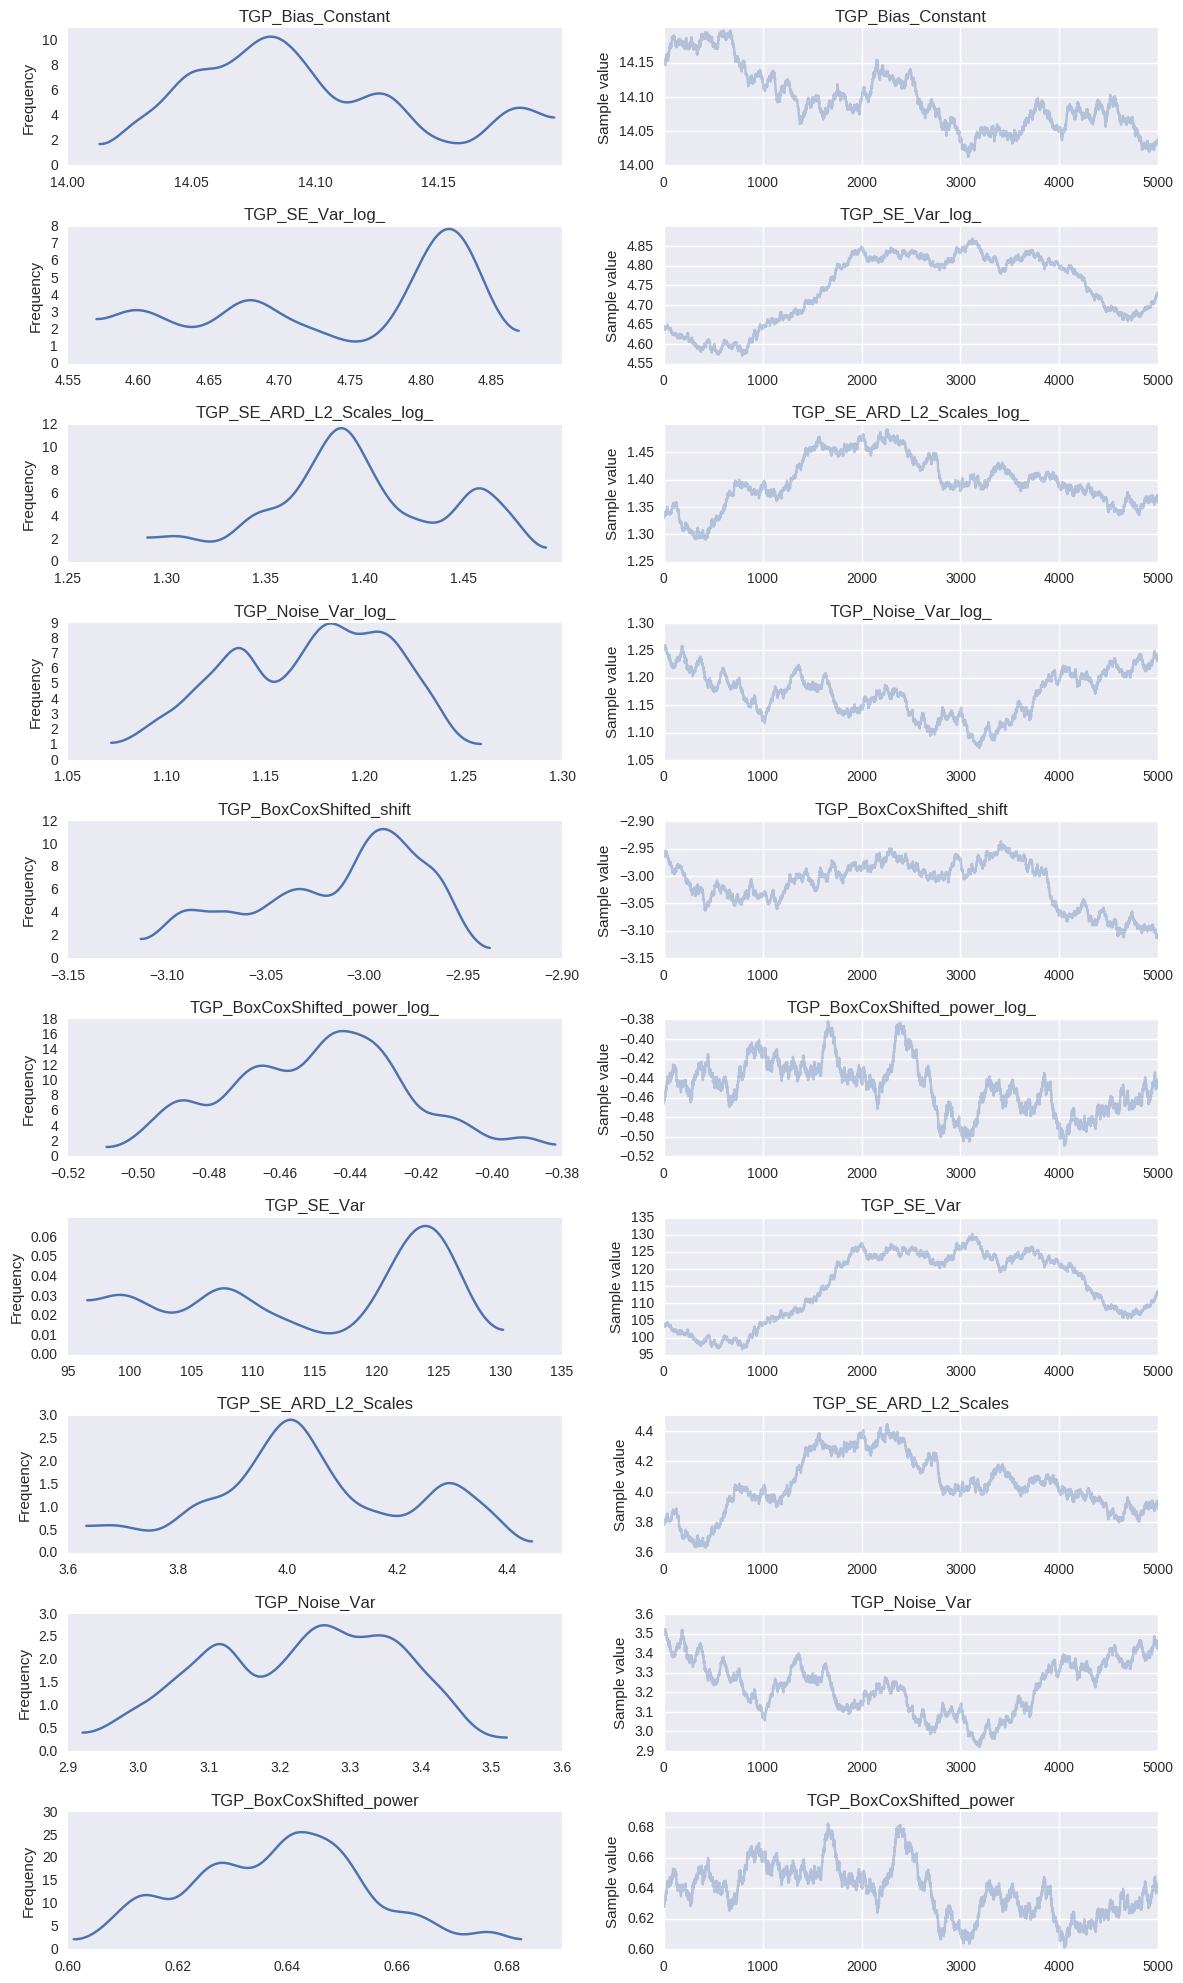

In [35]:
g3.style_seaborn()
g3.traceplot(traces)

In [36]:
datatraces = g3.datatrace(model, traces)
datatraces.describe().T

count         mean          std         min  \
TGP_BoxCoxShifted_power  5000.0     0.638512     0.016621    0.601113   
TGP_Noise_Var            5000.0     3.229571     0.134332    2.921129   
TGP_BoxCoxShifted_shift  5000.0    -3.014844     0.042314   -3.113024   
TGP_Bias_Constant        5000.0    14.096466     0.045496   14.012888   
TGP_SE_ARD_L2_Scales     5000.0     4.046465     0.185261    3.633812   
TGP_SE_Var               5000.0   114.772102     9.903025   96.581650   
niter                    5000.0  2499.500000  1443.520003    0.000000   
ll                       5000.0  -220.326667     0.421317 -221.826431   
adll                     5000.0    22.858848    13.052166    3.765648   

                                 25%          50%          75%          max  
TGP_BoxCoxShifted_power     0.626411     0.639566     0.649058     0.682543  
TGP_Noise_Var               3.118616     3.244425     3.337778     3.521736  
TGP_BoxCoxShifted_shift    -3.045724    -3.003240    -2.981907    -2.936547  
TGP_Bias_Constant          14.063066    14.087180    14.126783    14.196811  
TGP_SE_ARD_L2_Scales        3.935217     4.021948     4.187048     4.445282  
TGP_SE_Var                106.500416   118.026348   123.788420   130.226547  
niter                    1249.750000  2499.500000  3749.250000  4999.000000  
ll                       -220.540581  -220.216400  -220.041748  -219.672714  
adll                       12.053036    20.260312    31.487339    69.309052

/home/grios/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


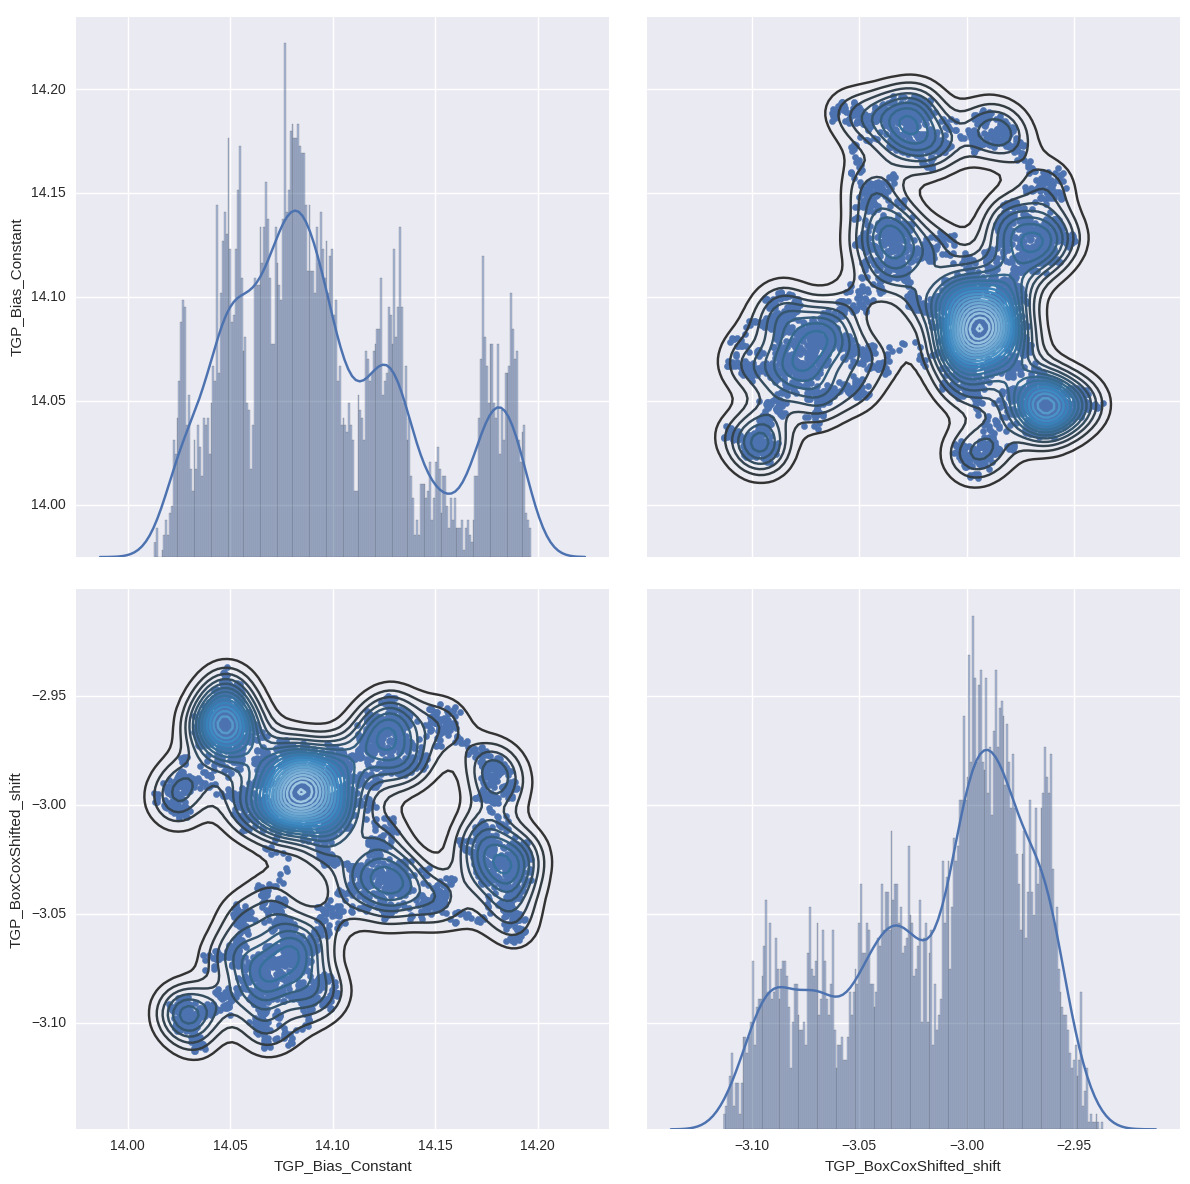

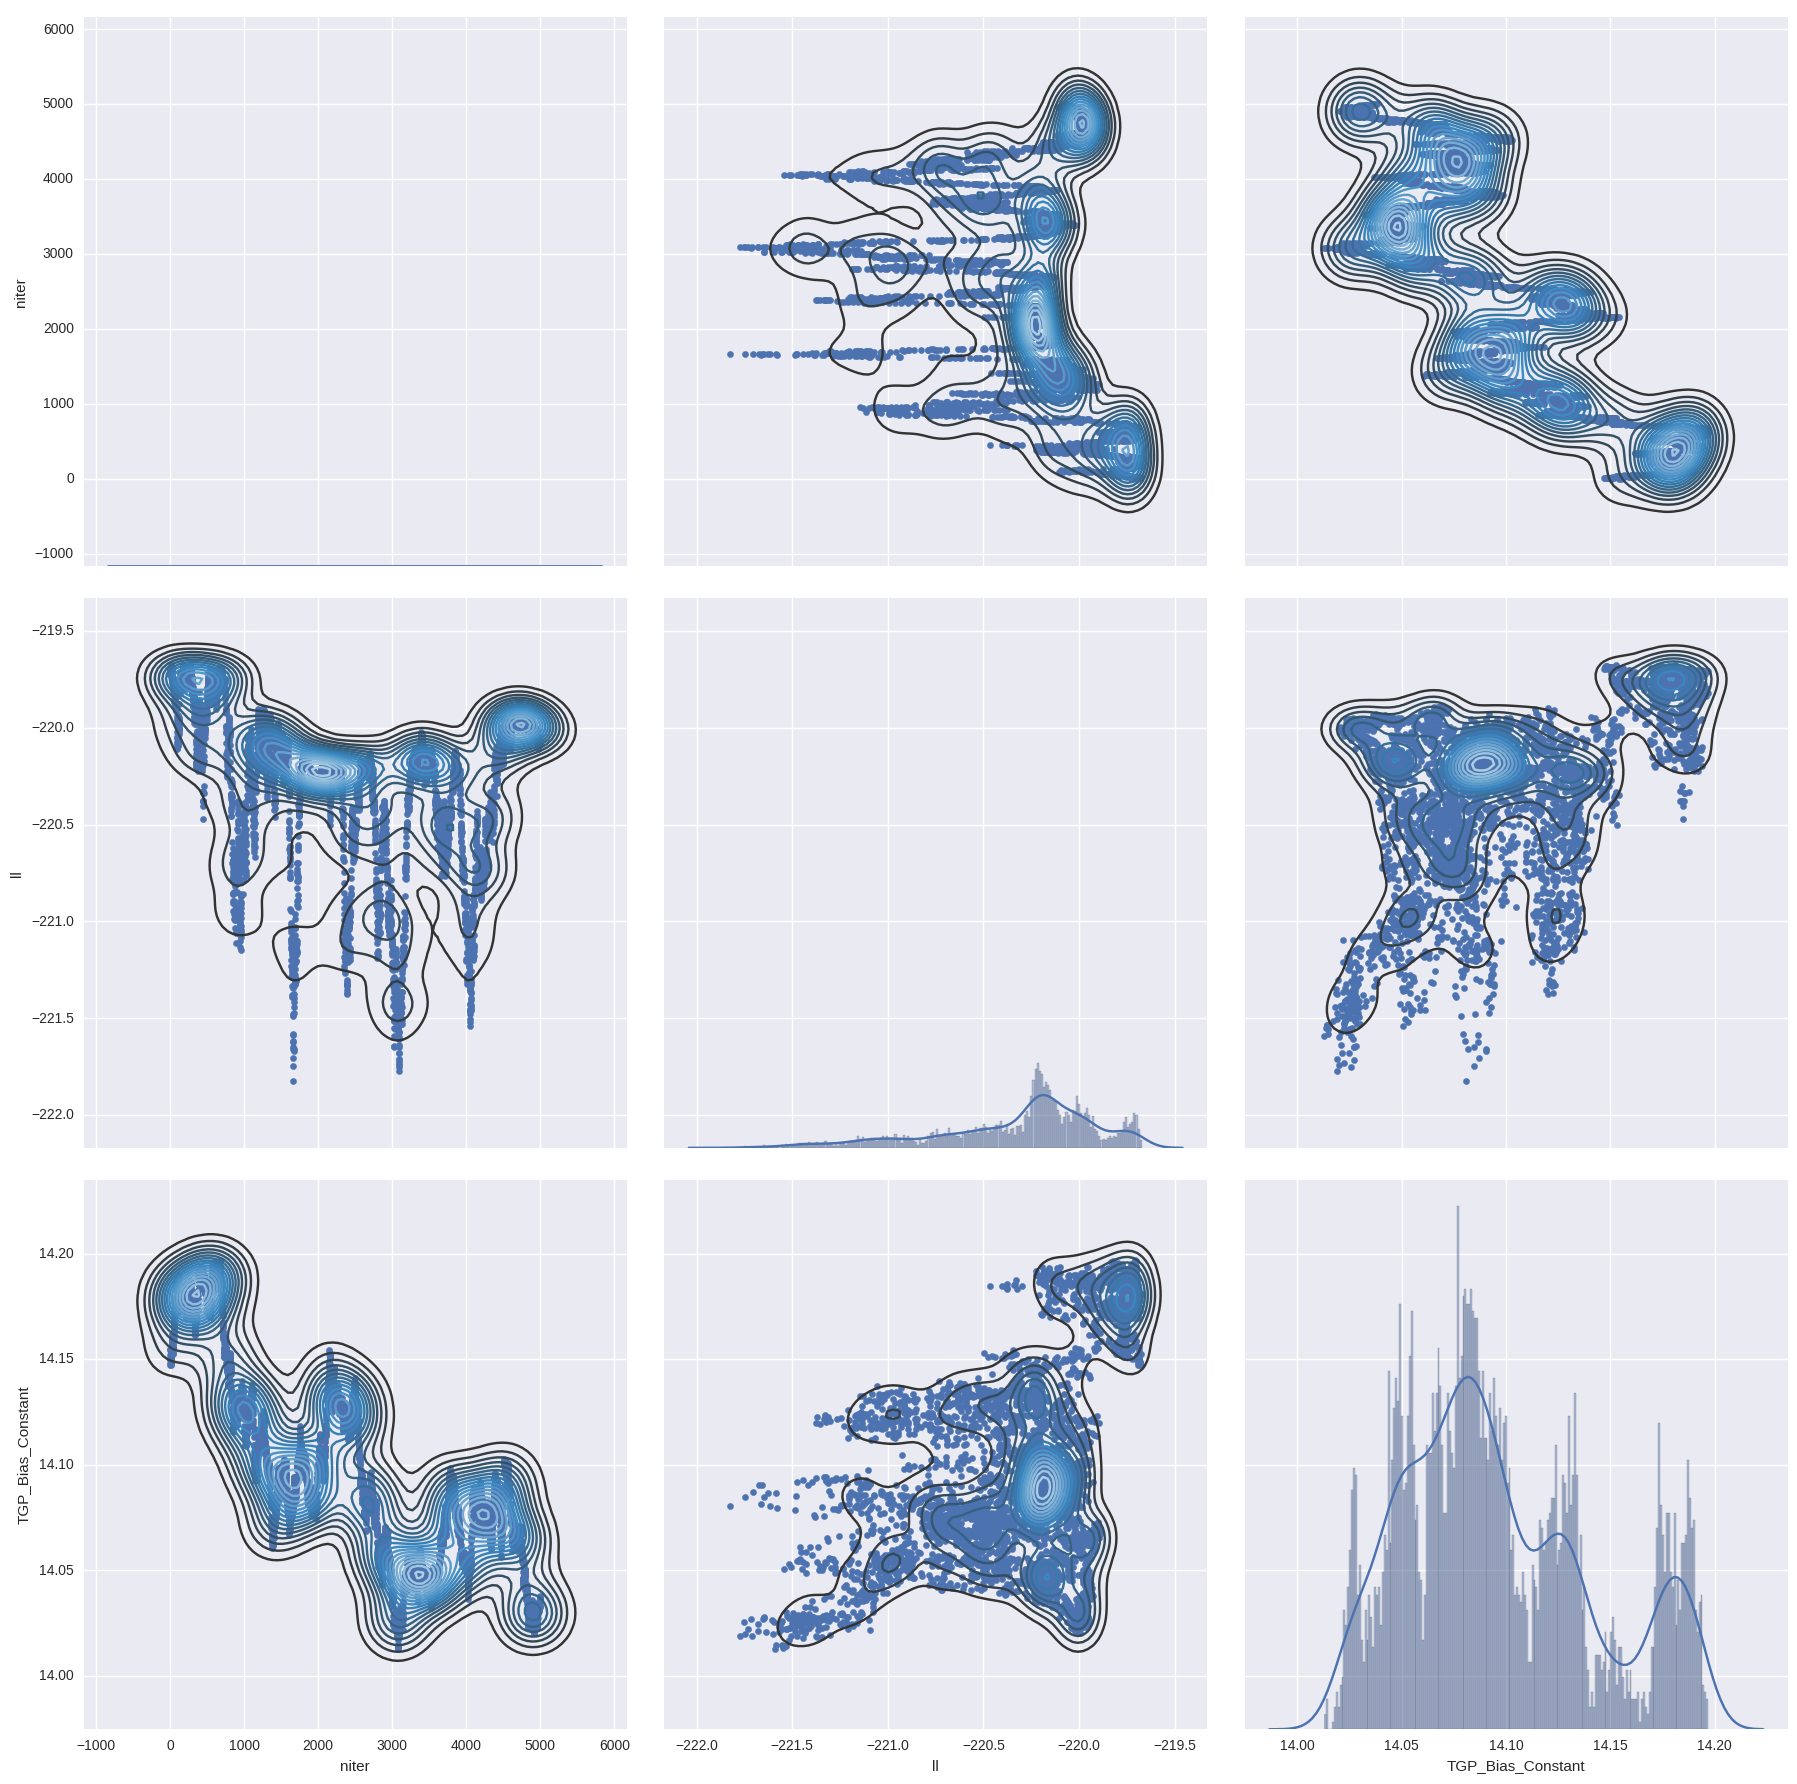

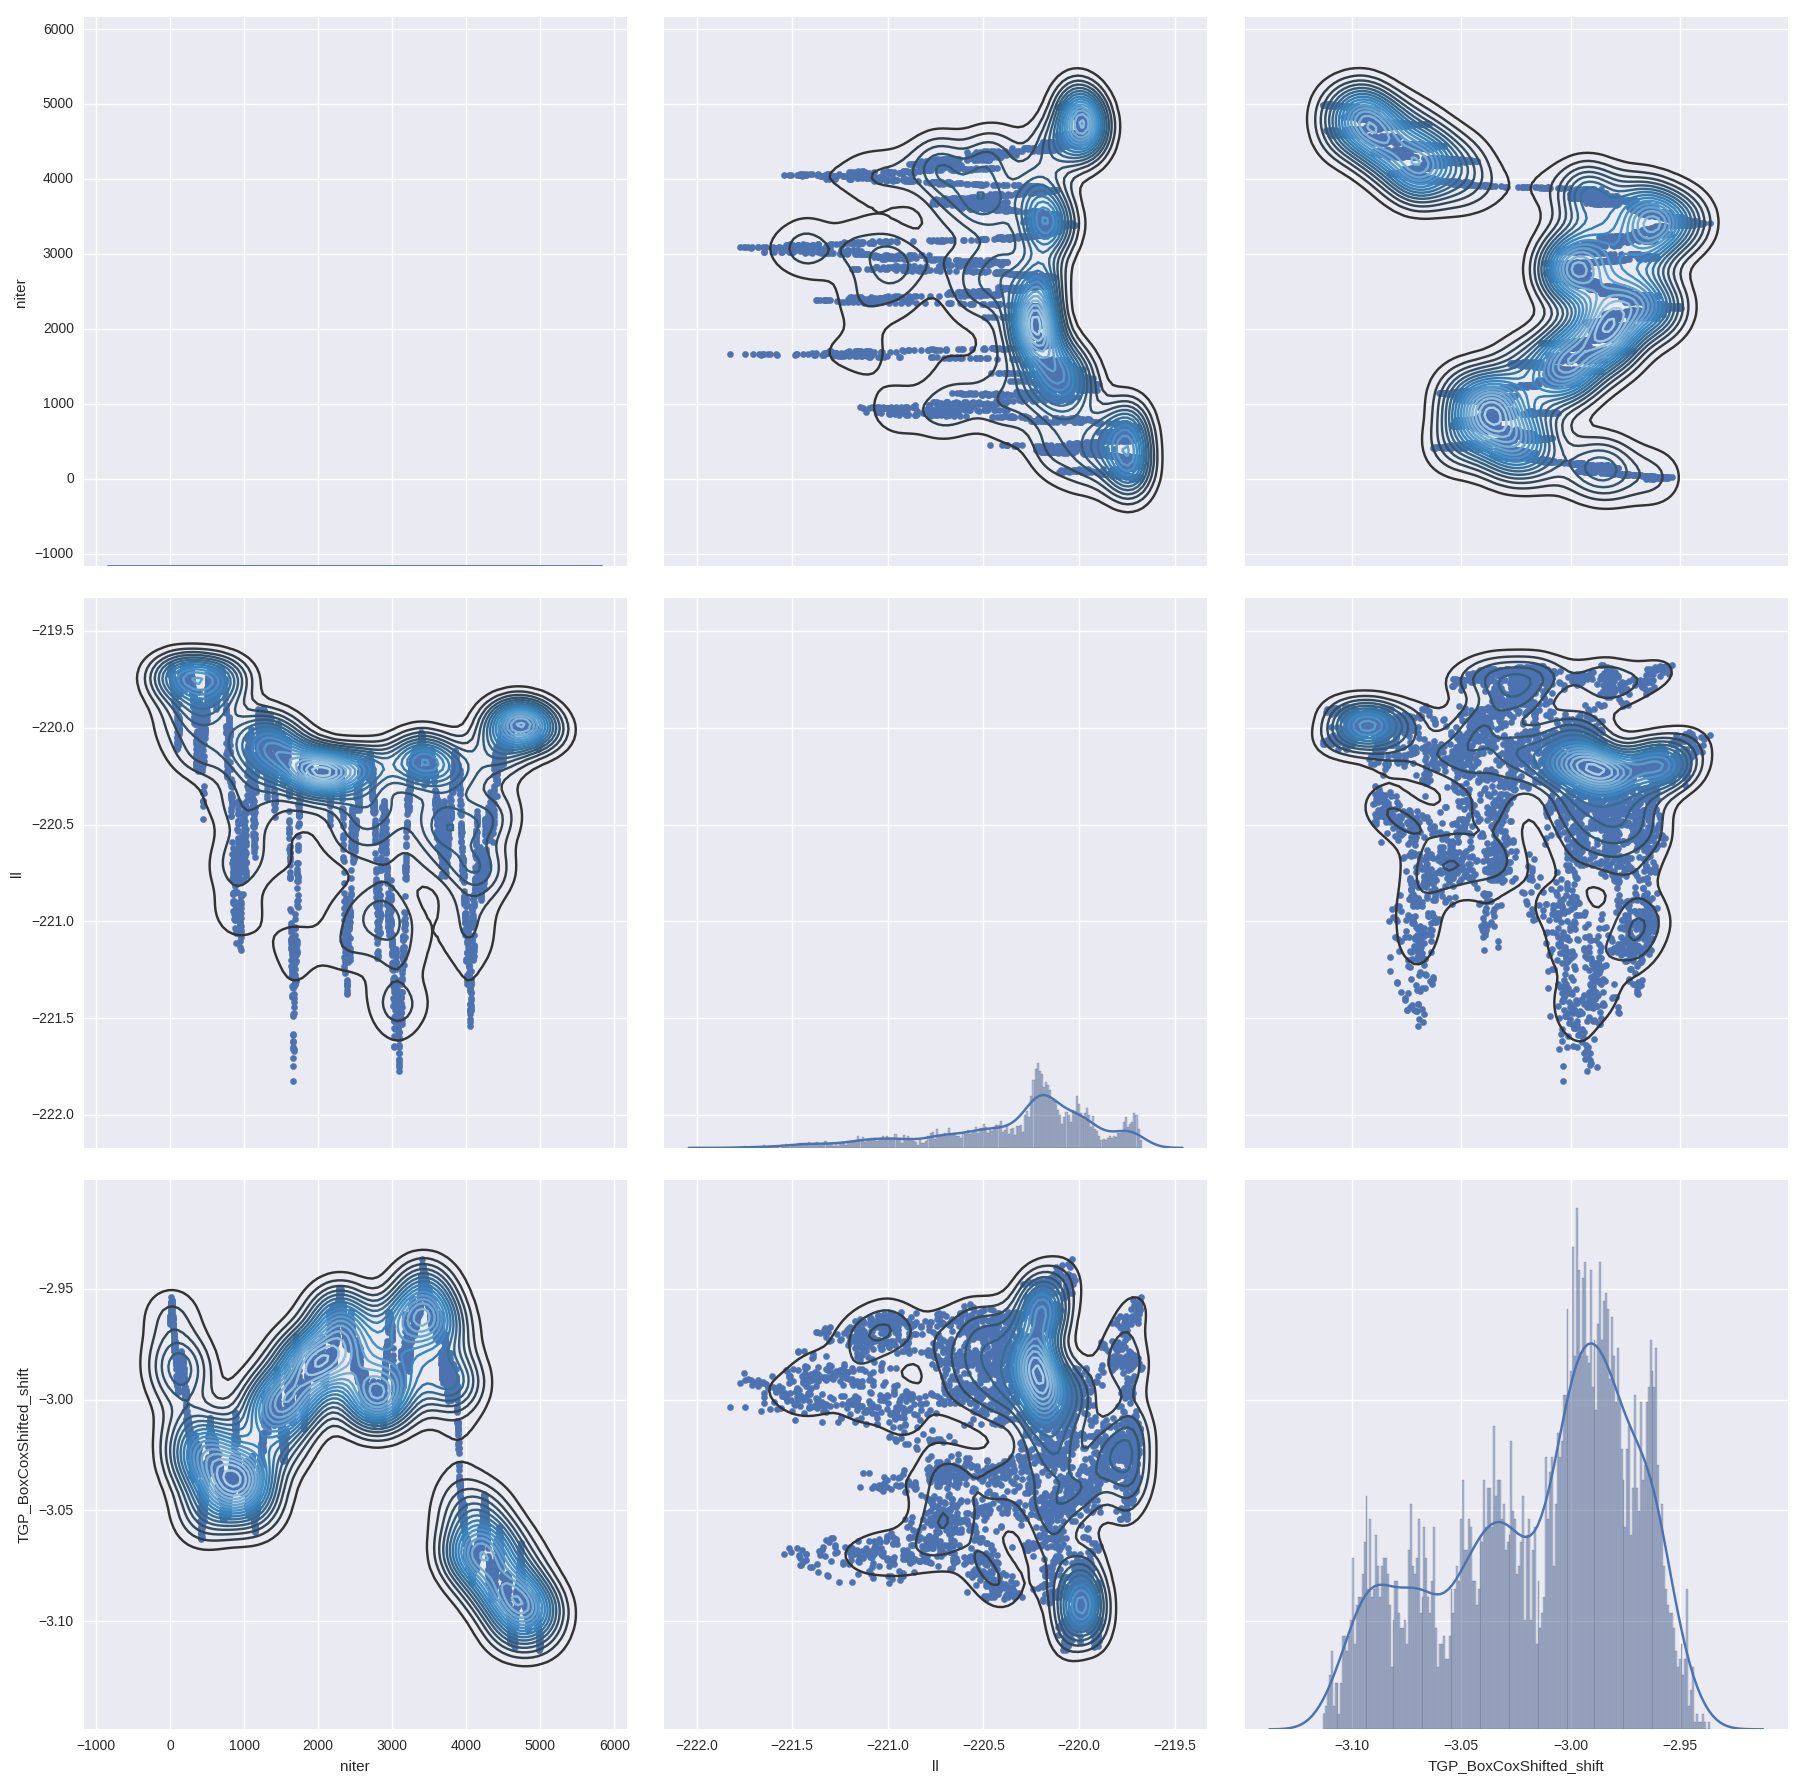

In [37]:
items_ll = ['niter','ll']
items_mt = ['TGP_Bias_Constant', 'TGP_Noise_Var_log_','TGP_SE_Var_log_']
items_k = ['TGP_BoxCoxShifted_power_log_','TGP_BoxCoxShifted_shift','TGP_SE_ARD_L2_Scales_log_']

g3.plot_datatrace(datatraces,items_mt+items_k)
g3.plot_datatrace(datatraces,items_ll+items_mt)
g3.plot_datatrace(datatraces,items_ll+items_k)

In [38]:
g3.style_big_seaborn()

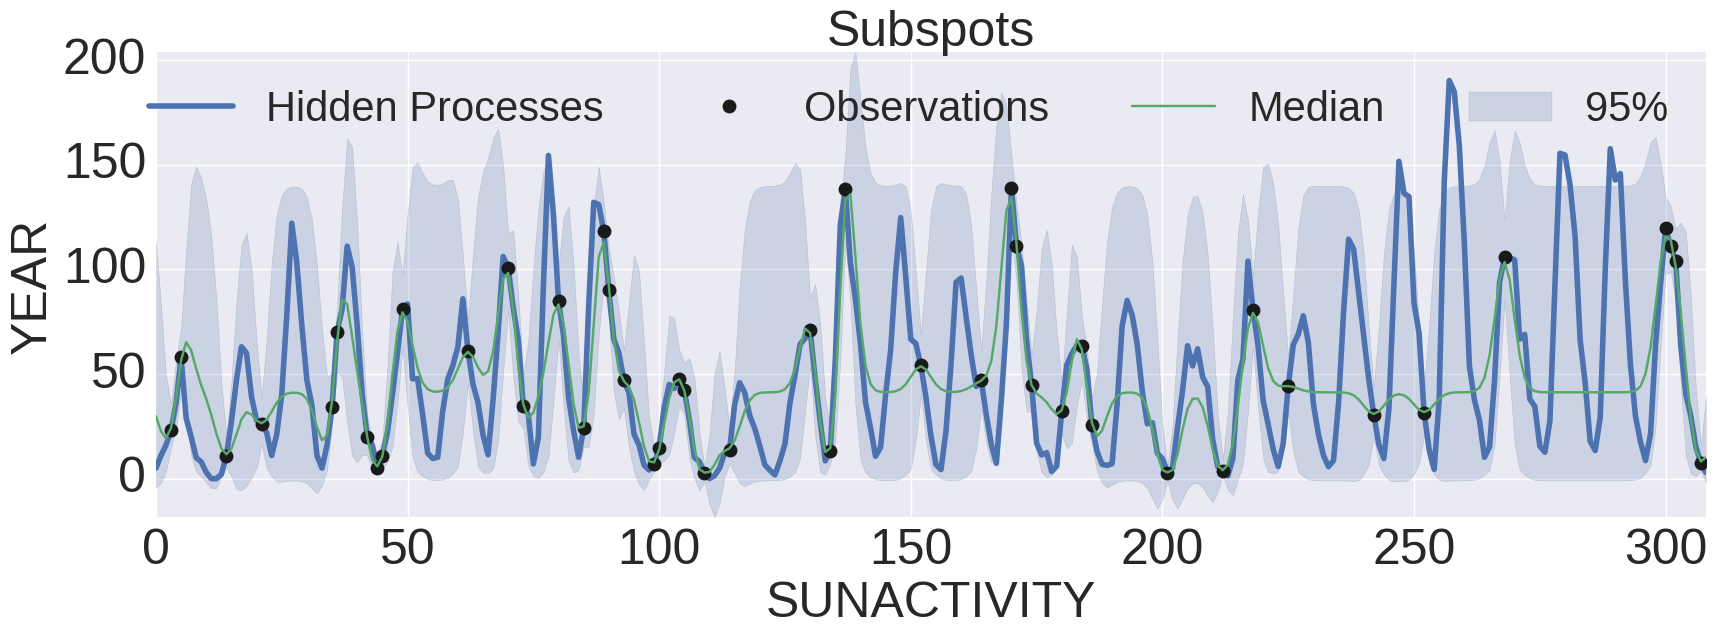

In [46]:
tgp.widget_trace(traces)